In [80]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import datetime, timedelta
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/world-cities-datasets/worldcities.csv


In [81]:
# Фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [82]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [83]:
# Загружаем данные
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
# Подгрузим датасет с информацией о городах 
df_cities = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')

In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [85]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [86]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [87]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [88]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [89]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [90]:
df_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [91]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Взглянем на пропуски ещё раз.

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

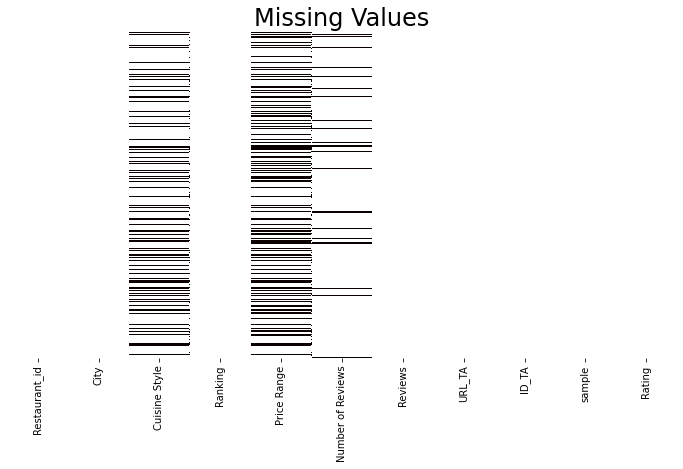

In [92]:
fig = plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.isnull(), cbar=False, cmap='hot_r', yticklabels=[]).set_title('Missing Values', fontsize=24)
df.isna().sum()

In [93]:
# Оставим в загруженном датасете с городами нужную информацию
df_cities = df_cities.rename(columns = {'city': 'City'})
df_cities = df_cities[(df_cities.City.isin(df.City.values)) & (df_cities.capital == 'primary')].sort_values(by = 'City')
df_cities = df_cities[['City','population', 'country', 'capital']]

In [94]:
# Загрузим интересующую нас информацию о городах в основной датасет
df_cities = df_cities.rename(columns = {'city': 'City'})
df_cities = df_cities[(df_cities.City.isin(df.City.values)) & (df_cities.capital == 'primary')].sort_values(by = 'City')
df_cities = df_cities[['City','population', 'country', 'capital']]
# Переведем население в миллионы человек
df_cities['population'] = df_cities['population'].apply(lambda x: x/1_000_000)
df = df.merge(df_cities, how = 'left', on = 'City')
df['population'].fillna(df['population'].mean(), inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  population         50000 non-null  float64
 12  country            37238 non-null  object 
 13  capital            37238 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 5.7+ MB


Подробнее по признакам:

Restaurant_id: ID ресторана

City: Город

Cuisine Style: Кухня

Ranking: Ранг ресторана относительно других ресторанов в этом городе

Price Range: Цены в ресторане в 3 категориях

Number of Reviews: Количество отзывов

Reviews: 2 последних отзыва и даты этих отзывов

URL_TA: страница ресторана на 'www.tripadvisor.com'

ID_TA: ID ресторана в TripAdvisor

Rating: Рейтинг ресторана

Population: население города

Country: страна нахождения города

Capital: является ли город столицей

# EDA

Взглянем на распределение признака.

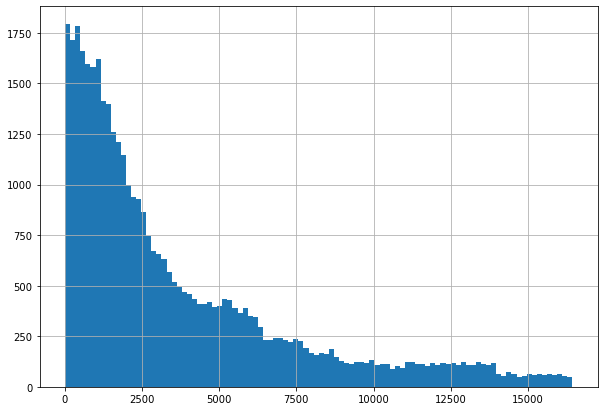

In [96]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

Распределение смещено влево. Скорее всего это произошло из-за того, что количество ресторанов отличается в разных городах.

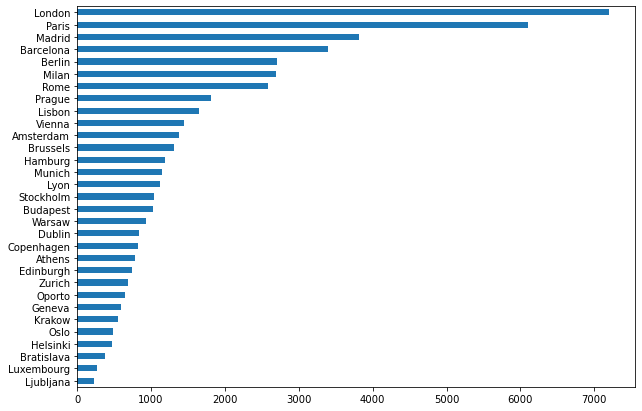

In [97]:
df['City'].value_counts(ascending=True).plot(kind='barh')

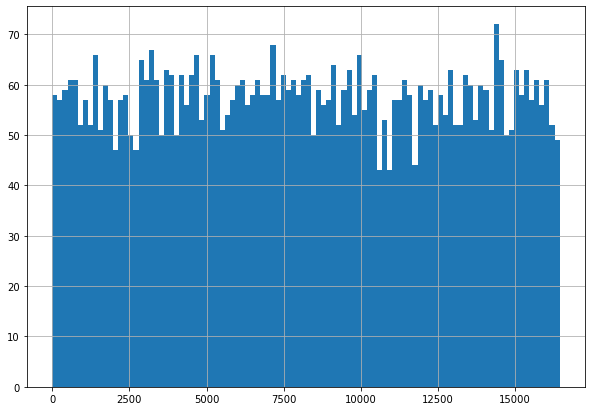

In [98]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

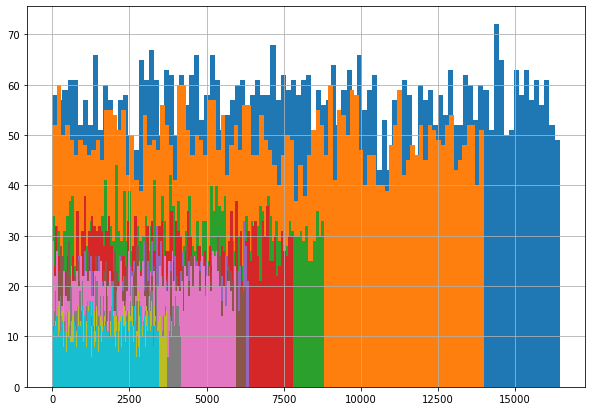

In [99]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

Посмотрим на распределение целевой переменной.

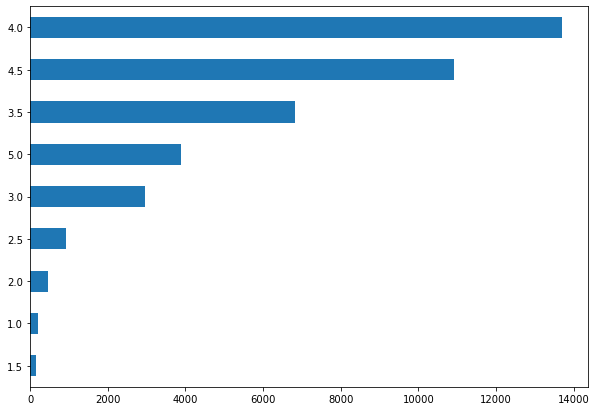

In [100]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Посмотрим на распределение оценки в зависимости от рейтинга

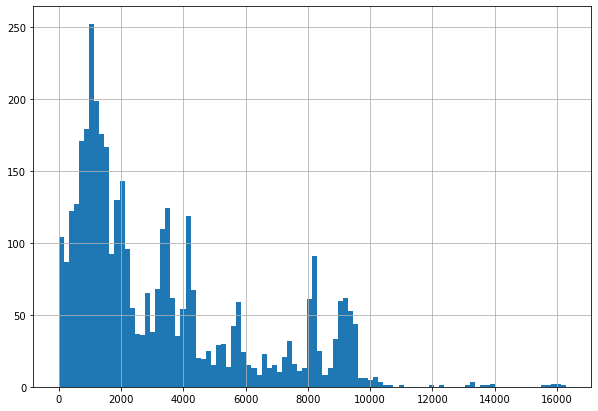

In [101]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

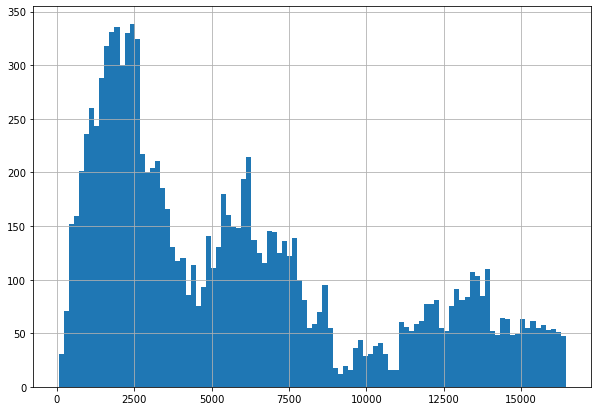

In [102]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

# Prepocessing

In [104]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

df_cities = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')
df_cities = df_cities.rename(columns = {'city': 'City'})
df_cities = df_cities[(df_cities.City.isin(data.City.values)) & (df_cities.capital == 'primary')].sort_values(by = 'City')
df_cities = df_cities[['City','country','population', 'capital']]
df_cities['population'] = df_cities['population'].apply(lambda x: x/1_000_000)
data = data.merge(df_cities, how = 'left', on = 'City')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  country            37238 non-null  object 
 12  population         37238 non-null  float64
 13  capital            37238 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 5.7+ MB


### Создадим класс, в который поместим часть предобработки

In [105]:
class Preproc():
    """Класс для предобработки"""

    def __init__(self, data):
        """Инициализируем класс и применим к объекту все методы для предобработки"""
        self.data = data        
        self.edit_cuisine(self.data)
        self.cuisine_types(self.data)
        self.reviews_date(self.data)
        #self.reviews_weekday(self.data)
        self.convert_capitals(self.data)
        self.converted_price(self.data)
        self.fill_price(self.data)
        self.fill_reviews_num(self.data)
        self.fill_population(self.data)
        self.reviews_gap(self.data)
        self.fill_gaps(self.data)
        self.time_from_last_review(self.data)
        self.fill_time_from_lr(self.data)

    # Создаем списки кухонь
    def edit_cuisine(self, data):
        pattern = re.compile('\w+\s*\w*')
        self.data['Cuisine Style'] = self.data['Cuisine Style'].apply(lambda x: pattern.findall(x) if pd.isna(x)==False else [])
        
    # Содаем новый признак с количеством представленных кухонь
    def cuisine_types(self, data):
        def count_types(row):
            try:
                return len(row)
            except:
                return 1
        self.data['Number of Cuisine Types'] = self.data['Cuisine Style'].apply(count_types)
    
    # Определим дату последних отзывов
    def reviews_date(self, data):
        # Создадим временный признак, содержащий даты отзывов
        def catch_date(row):
            pattern_date = re.compile('\d\d\/\d\d\/\d\d\d\d')
            try:
                result = re.findall(pattern_date, row)
                return result
            except:
                return np.nan        
        # Дата последнего отзыва
        def last_review(dates):
            date_temp = []
            try:
                for date in dates:
                    date = pd.Timestamp(date)
                    date_temp.append(date)
                return max(date_temp)
            except:
                return np.nan
        # Дата второго отзыва
        def second_review(dates):
            date_temp = []
            try:
                for date in dates:
                    date = pd.Timestamp(date)
                    date_temp.append(date)
                if len(date_temp) > 1:
                    return min(date_temp)
                else:
                    return np.nan
            except:
                return np.nan
        self.data['Reviews Date'] = self.data['Reviews'].apply(catch_date)
        self.data['Last Review'] = self.data['Reviews Date'].apply(last_review)
        self.data['Second Review'] = self.data['Reviews Date'].apply(second_review)
    
    #  Создадим новые признаки из дат отзывов,
    # обозначающие день недели, когда был оставлен отзыв
    # С этим признаком результат хуже
    def reviews_weekday(self, data):
        def convert_to_weekday(row):
            try:
                if row.weekday() > 4:
                    return 1
                else:
                    return 0
            except:
                return 0
        self.data['Last Review Weekend'] = self.data['Last Review'].apply(convert_to_weekday)
        self.data['Second Review Weekend'] = self.data['Second Review'].apply(convert_to_weekday)
    
    # Конвертируем Price Range в числовые значения
    def converted_price(self, data):
        def convert_price(row):
            if row == '$':
                return 1
            elif row == '$$ - $$$':
                return 2
            elif row == '$$$$':
                return 3
        self.data['Converted Price'] = self.data['Price Range'].apply(convert_price)     
    
    # Заполним пропуски в Price Range
    def fill_price(self, data):
        self.data['Converted Price'].fillna(0, inplace=True)
    
    # Заполним пропуски в Number of Reviews
    def fill_reviews_num(self, data):
        self.data['Number of Reviews'].fillna(0, inplace=True)
    
    # Заполним пропуски в Population
    def fill_population(self, data):
        self.data['population'].fillna(self.data['population'].mean(), inplace=True)
    
    # Конвертируем признак, обозначающий столицу, в числовой формат
    def convert_capitals(self, data):
        def convert_to_numbers(row):
            if row == 'primary':
                return 1
            else:
                return 0
        self.data['Capitals Conv'] = self.data['capital'].apply(convert_to_numbers)
    
    # Определим разницу между последним и предпоследним отзывом
    def reviews_gap(self, data):
        def count_gap(row):
            try:
                gap = row['Last Review'] - row['Second Review']
                return gap.days
            except:
                return np.nan
        self.data['Reviews Gap'] = self.data.apply(count_gap, axis=1)
    
    # Сразу заполним пропуски медианным значением
    def fill_gaps(self, data):
        self.data['Reviews Gap'].fillna(self.data['Reviews Gap'].median(), inplace=True)
    
    #  Определим сколько дней прошло с момента последнего отзыва.
    # Будем считать, что самый последний отзыв написан сегодня.
    def time_from_last_review(self, data):
        def count_time(row):
            try:
                gap = self.data['Last Review'].max() - row['Last Review']
                return gap.days
            except:
                return np.nan
        self.data['Last Review Days'] = self.data.apply(count_time, axis=1)
        
    # Сразу заполним пропуски медианным значением
    def fill_time_from_lr(self, data):
        self.data['Last Review Days'].fillna(self.data['Last Review Days'].median(), inplace=True)

In [ ]:
Preproc(data)

# Feature Engineering

In [ ]:
# Определим средний показатель ресторанов на миллион человек
rest_quantity = data.groupby(by='City').count()['Ranking']
city_population = data.groupby(by='City').mean()['population']
rest_per_people = rest_quantity / city_population

# Добавим новые признаки
# Количество людей на ресторан
rest_per_people = rest_per_people.reset_index()
rest_per_people.columns = ['City', 'Man per Rest']
# Количество ресторанов в городе
rest_quantity = rest_quantity.reset_index()
rest_quantity.columns = ['City', 'Number of Rest']
# Средняя оценка по городу
rating_per_city = data.groupby(by='City').mean()['Rating'].reset_index()
rating_per_city.columns = ['City', 'Rating per City']


# Присоеденим новые признаки к основному датасету
data = data.merge(rest_quantity, how='left', on='City')
data = data.merge(rest_per_people, how='left', on='City')
data = data.merge(rating_per_city, how='left',on='City')

Создадим dummy-переменные

In [ ]:
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

temp = pd.get_dummies(data['Cuisine Style'].explode()).groupby(level = 0).sum()
data = data.join(temp)

data = pd.get_dummies(data, columns=['country'], dummy_na=True)

Взглянем на корреляцию полученных признаков

In [ ]:
sns.heatmap(data.corr())

# Remove Objects

Уберем объекты типа object

In [ ]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis=1, inplace=True)

Уберем объекты типа datetime

In [ ]:
data_columns = [s for s in data.columns if data[s].dtypes == 'datetime64[ns]']
data.drop(data_columns, axis=1, inplace=True)

# Splitting Dataset

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

#### Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [ ]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
#  Т.к рейтинг представлен с шагом в 0.5, то мы тоже округлим наши предсказания.
# Напишем для этого функцию.
def round_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [ ]:
# Теперь округлим полученные значения.
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
# Round
for i in range(len(predict_submission)):
    predict_submission[i] = round_rating_pred(predict_submission[i])

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)